## 회귀 분석

#### 기존의 '서울시격자중심점_좌표수정_회수로봇.xlsx' 은 엑셀을 통해서 MinMaxScaling을 해준 다음에 'sc_data_m.xlsx'로 저장했습니다.

In [24]:
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import numpy as np
import pandas as pd
import os

In [32]:
mclp_data = pd.read_excel(os.getcwd() + "\\dataset\\sc_data_m.xlsx",index_col=0)

In [33]:
mclp_data

,left,bottom,right,top,거주인구,utmk_x,utmk_y,배달인구_평균,유동인구_평균,1인가구,...,ycoord,네프론,위빈,Sssaem,공공시설,공원,역,회수합,sc_역,sc_버스정류소
0,935000,1950800,935100,1950900,0.0,935050,1950850,0.0,0.0,0.0,...,37.554709,0,0,0,0,0,0,0,0.0,0.000000
1,935000,1950900,935100,1951000,0.0,935050,1950950,0.0,0.0,0.0,...,37.555611,0,0,0,0,0,0,0,0.0,0.000000
2,935100,1950700,935200,1950800,0.0,935150,1950750,0.0,0.0,0.0,...,37.553815,0,0,0,0,0,0,0,0.0,0.000000
3,935100,1950800,935200,1950900,0.0,935150,1950850,0.0,0.0,0.0,...,37.554716,0,0,0,0,0,0,0,0.0,0.000000
4,935100,1950900,935200,1951000,0.0,935150,1950950,0.0,0.0,0.0,...,37.555618,0,0,0,0,0,0,0,0.0,0.029412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61645,972000,1949500,972100,1949600,0.0,972050,1949550,0.0,0.0,0.0,...,37.544858,0,0,0,0,0,0,0,0.0,0.000000
61646,972000,1949600,972100,1949700,0.0,972050,1949650,0.0,0.0,0.0,...,37.545759,0,0,0,0,0,0,0,0.0,0.000000
61647,972000,1949900,972100,1950000,0.0,972050,1949950,0.0,0.0,0.0,...,37.548463,0,0,0,0,0,0,0,0.0,0.000000
61648,972000,1950100,972100,1950200,0.0,972050,1950150,0.0,0.0,0.0,...,37.550266,0,0,0,0,0,0,0,0.0,0.000000


In [34]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

df_LR = mclp_data.copy()
X = df_LR[["sc_거주인구","sc_유동인구_평균","sc_배달인구_평균","sc_1인가구","sc_역", 'sc_버스정류소']]
y = df_LR["회수합"]

In [38]:
X.corr()

,sc_거주인구,sc_유동인구_평균,sc_배달인구_평균,sc_1인가구,sc_역,sc_버스정류소
sc_거주인구,1.000000,0.078139,0.772212,0.514775,0.062029,0.392151
sc_유동인구_평균,0.078139,1.000000,0.092990,0.096624,0.039114,0.066405
sc_배달인구_평균,0.772212,0.092990,1.000000,0.676814,0.098412,0.471445
sc_1인가구,0.514775,0.096624,0.676814,1.000000,0.148204,0.388110
sc_역,0.062029,0.039114,0.098412,0.148204,1.000000,0.263969
sc_버스정류소,0.392151,0.066405,0.471445,0.388110,0.263969,1.000000


In [40]:
regr = linear_model.LinearRegression()
regr.fit(X, y)
print(regr.coef_)
regr.score(X, y)

[0.05770434 0.02319298 0.20798287 0.48229058 0.22242704 0.20572718]


0.03038189079475162

# MCLP

In [41]:
!pip install mip

You should consider upgrading via the 'c:\users\pc\anaconda3\python.exe -m pip install --upgrade pip' command.


In [44]:
import numpy as np
import pandas as pd
import time
from scipy.spatial import distance_matrix

##########################    mclp    ###########################
#######input
#points -> 커버해야할 포인트들(2차원 nparray). ex) [[0,0], [127,127]]
#K -> 설치할 기기의 수(int)
#radius -> 한 기기당 커버 가능한 범위
#w -> 포인트들의 중요도(wight) 벡터
#sites -> 설치가 가능한 위치

#######output
#opt_sites
#m.objective_value
#################################################################
def mclp(points:np.ndarray, K, radius, w, sites:np.ndarray):
    """
    Solve maximum covering location problem
    Input:
        points: input points, Numpy array in shape of [N,2]
        K: the number of sites to select
        radius: the radius of circle
        M: the number of candidate sites, which will randomly generated inside
        the ConvexHull wrapped by the polygon
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    print('----- Configurations -----')
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)

    start = time.time()
    J = sites.shape[0]
    I = points.shape[0]
    D = distance_matrix(points,sites)
    mask1 = D<=radius
    D[mask1]=1
    D[~mask1]=0

    from mip import Model, xsum, maximize, BINARY

    # Build model
    m:Model = Model("mclp")

    # Add variables
    x = [m.add_var(name = "x%d" % j, var_type = BINARY) for j in range(J)]
    y = [m.add_var(name = "y%d" % i, var_type = BINARY) for i in range(I)]

    m.objective = maximize(xsum(w[i]*y[i] for i in range (I)))

    m += xsum(x[j] for j in range(J)) == K

    for i in range(I):
        m += xsum(x[j] for j in np.where(D[i]==1)[0]) >= y[i]

    m.optimize()

    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objective_value)

    solution = []
    for i in range(J):
        if x[i].x ==1:
            solution.append(int(x[i].name[1:]))
    opt_sites = sites[solution]

    return opt_sites, m.objective_value

def plot_input(points):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)
    plt.show()

def plot_result(points,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    plt.scatter(opt_sites[:,0],opt_sites[:,1],c='C1',marker='+')
    for site in opt_sites:
        circle = plt.Circle(site, radius, color='C1',fill=False,lw=2)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)
    plt.show()

In [58]:
!pip install pyarrow

You should consider upgrading via the 'c:\users\pc\anaconda3\python.exe -m pip install --upgrade pip' command.


In [59]:
pd.io.parquet.get_engine('auto')

In [61]:
import os

mclp_data = pd.read_parquet(os.getcwd() + "\\dataset\\mclpdata.parquet")
facilities = pd.read_excel(os.getcwd() + "\\dataset\\candidate.xlsx", index_col=0)

# 회귀분석을 통해 얻은 각 변수들의 coef값을 weights에 할당
columns = ["sc_거주인구","sc_유동인구_평균","sc_배달인구_평균","sc_1인가구", "sc_역", "sc_버스정류소"]
#weights = [ 0.10433166, 0,  0.63602281,  0.37473875,  0.2143527,   0.39891326]
weights = [ 0.03737391, -0.16562362,  0.43588364, 0.21223976,  0.27335295,  0.49963512]
score = 0
for col, weight in zip(columns, weights):
  score+=mclp_data[col]*weight
mclp_data['입지점수'] = score

In [62]:
mclp_data['입지점수'].sum()

7438.549674859805

In [63]:
gu_rank_df = pd.read_csv(os.getcwd() + "\\dataset\\구 우선순위.csv")
gu_rank_df['0'][:25]

0      강서구
1      송파구
2      강남구
3      관악구
4      노원구
5      은평구
6      서초구
7      마포구
8      성북구
9     영등포구
10     동작구
11     중랑구
12     양천구
13     구로구
14    동대문구
15     광진구
16     성동구
17    서대문구
18     도봉구
19     강북구
20     용산구
21      중구
22     종로구
23     금천구
24     강동구
Name: 0, dtype: object

In [64]:
facilities

,xcoord,ycoord,주소,구
0,127.016343,37.570719,대한민국 서울특별시 종로구 창신동 401-3,종로구
1,127.015628,37.577823,대한민국 서울특별시 종로구 숭인1동 55-2,종로구
2,126.984789,37.580051,대한민국 서울특별시 종로구 가회동 156,종로구
3,126.981857,37.585005,대한민국 서울특별시 종로구 삼청동 삼청로 107,종로구
4,126.970621,37.584092,대한민국 서울특별시 종로구 궁정동 9-6,종로구
...,...,...,...,...
127,127.095997,37.579762,용마도시자연공원(사가정공원),중랑구
128,126.893246,37.571718,문화비축기지,마포구
129,127.076482,37.627077,경춘선숲길,노원구
130,127.115594,37.472332,율현공원,강남구


In [65]:
sites = np.asarray([[xcoord, ycoord] for xcoord, ycoord in zip(facilities[facilities['구']=='강서구']['xcoord'], facilities[facilities['구']=='강서구']['ycoord']) ])
points = np.asarray([[xcoord, ycoord] for xcoord, ycoord in zip(mclp_data[mclp_data['구']=='강서구']['xcoord'], mclp_data[mclp_data['구']=='강서구']['ycoord']) ])

In [66]:
sites = np.asarray([[xcoord, ycoord] for xcoord, ycoord in zip(facilities[facilities['구']=='송파구']['xcoord'], facilities[facilities['구']=='송파구']['ycoord']) ])
points = np.asarray([[xcoord, ycoord] for xcoord, ycoord in zip(mclp_data[mclp_data['구']=='송파구']['xcoord'], mclp_data[mclp_data['구']=='송파구']['ycoord']) ])

In [67]:
points

array([[127.06830141,  37.51564913],
       [127.06829622,  37.51655047],
       [127.06829102,  37.5174518 ],
       ...,
       [127.16003147,  37.49972427],
       [127.16002738,  37.50062562],
       [127.1611628 ,  37.49972752]])

In [68]:
sites

array([[127.10212422,  37.49841164],
       [127.14393782,  37.48116565],
       [127.08529697,  37.50322578],
       [127.08432588,  37.50613936],
       [127.0855525 ,  37.50304695],
       [127.08561991,  37.50315087],
       [127.08540848,  37.50339432],
       [127.08447052,  37.50360044],
       [127.10985447,  37.49650409],
       [127.10943985,  37.49636852],
       [127.08854088,  37.51189164],
       [127.11673676,  37.50231838],
       [127.12406781,  37.49560318],
       [127.13965995,  37.4957864 ],
       [127.10931236,  37.50626358],
       [127.14853433,  37.49684226],
       [127.09421729,  37.50726532],
       [127.07335607,  37.51096932],
       [127.08637391,  37.51156726],
       [127.10031269,  37.513319  ],
       [127.11242994,  37.51762366],
       [127.14994826,  37.49600274],
       [127.11081276,  37.53141295],
       [127.11445138,  37.51455579],
       [127.10381104,  37.52068676],
       [127.12787921,  37.50226602],
       [127.13515858,  37.49781467],
 

In [70]:
print(len(points))
print(len(sites))

3382
69


In [71]:
radius = (1/88.74/1000)*500 # covered distance 500m
w = mclp_data[mclp_data['구']=='강서구']['입지점수'].to_list()

In [72]:
opt_sites,f = mclp(points, 12, radius, w, sites)

----- Configurations -----
  Number of points 3382
  K 12
  Radius 0.00563444
----- Output -----
  Running time : 5.835703372955322 seconds
  Optimal coverage points: 164.055


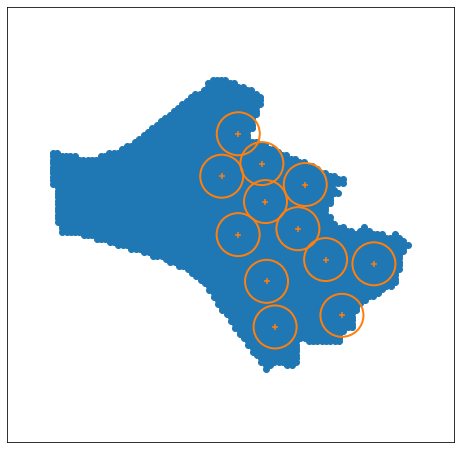

In [74]:
plot_result(points,opt_sites,radius)

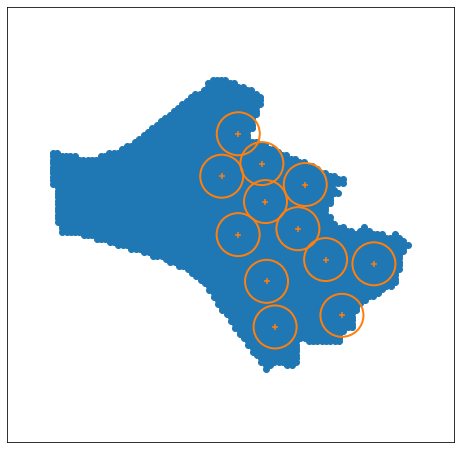

In [75]:
plot_result(points,opt_sites,radius)

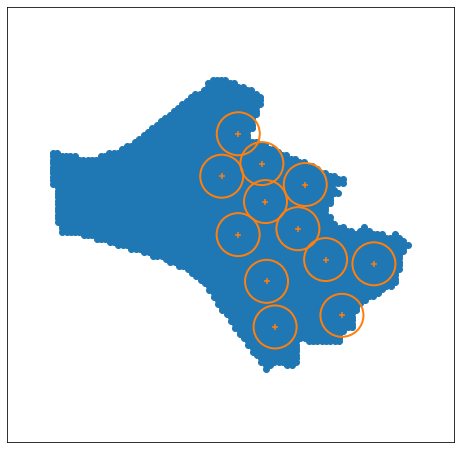

In [76]:
plot_result(points,opt_sites,radius)

In [77]:
for site in opt_sites:
  print(facilities[(facilities['xcoord']==site[0]) & (facilities['ycoord']==site[1])]['주소'])

308    대한민국 서울특별시 송파구 거여2동 503-1
Name: 주소, dtype: object
447    대한민국 서울특별시 송파구 송파2동 173
Name: 주소, dtype: object
449    대한민국 서울특별시 송파구 거여1동 19-12
Name: 주소, dtype: object
456    대한민국 서울특별시 송파구 잠실4동 20-8
Name: 주소, dtype: object
465    대한민국 서울특별시 송파구 풍납2동 403-11
Name: 주소, dtype: object
471    대한민국 서울특별시 송파구 마천동 183-94
Name: 주소, dtype: object
472    대한민국 서울특별시 송파구 문정동 29-21
Name: 주소, dtype: object
473    대한민국 서울특별시 송파구 방이동 89-10
Name: 주소, dtype: object
489    대한민국 서울특별시 송파구 장지동 262-3
Name: 주소, dtype: object
502    대한민국 서울특별시 송파구 방이동 200
Name: 주소, dtype: object
59    오금근린공원
Name: 주소, dtype: object
64    올림픽공원
Name: 주소, dtype: object


In [78]:
radius = (1/88.74/1000)*500 # covered distance 500m
w = mclp_data[mclp_data['구']=='송파구']['입지점수'].to_list()

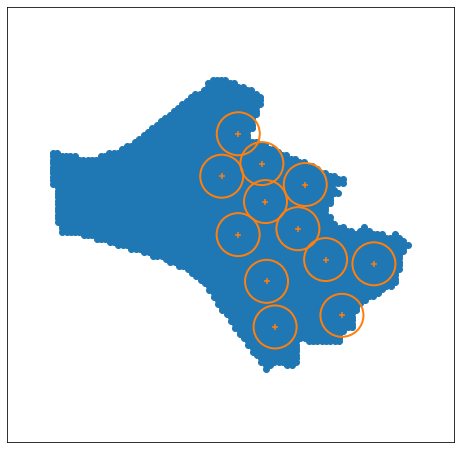

In [79]:
plot_result(points,opt_sites,radius)

In [80]:
opt_sites,f = mclp(points, 20, radius, w, sites)

----- Configurations -----
  Number of points 3382
  K 20
  Radius 0.00563444
----- Output -----
  Running time : 1.634838581085205 seconds
  Optimal coverage points: 270.799


In [81]:
for site in opt_sites:
  print(facilities[(facilities['xcoord']==site[0]) & (facilities['ycoord']==site[1])]['주소'])

157    대한민국 서울특별시 송파구 가락동 479-1
Name: 주소, dtype: object
446    대한민국 서울특별시 송파구 잠실2동 올림픽로 159
Name: 주소, dtype: object
447    대한민국 서울특별시 송파구 송파2동 173
Name: 주소, dtype: object
450    대한민국 서울특별시 송파구 송파1동 백제고분로 392
Name: 주소, dtype: object
459    대한민국 서울특별시 송파구 방이동 백제고분로 495
Name: 주소, dtype: object
462    대한민국 서울특별시 송파구 가락2동 167
Name: 주소, dtype: object
465    대한민국 서울특별시 송파구 풍납2동 403-11
Name: 주소, dtype: object
466    대한민국 서울특별시 송파구 삼전동 백제고분로 236
Name: 주소, dtype: object
471    대한민국 서울특별시 송파구 마천동 183-94
Name: 주소, dtype: object
473    대한민국 서울특별시 송파구 방이동 89-10
Name: 주소, dtype: object
489    대한민국 서울특별시 송파구 장지동 262-3
Name: 주소, dtype: object
491    대한민국 서울특별시 송파구 가락본동 214-5
Name: 주소, dtype: object
497    대한민국 서울특별시 송파구 신천동 신천로 29
Name: 주소, dtype: object
501    대한민국 서울특별시 송파구 잠실7동 올림픽로4길 17
Name: 주소, dtype: object
502    대한민국 서울특별시 송파구 방이동 200
Name: 주소, dtype: object
503    대한민국 서울특별시 송파구 가락2동 중대로20길 6
Name: 주소, dtype: object
512    대한민국 서울특별시 송파구 거여동 136-16
Name: 주소, dtype: object
59    오금근린공원
Name: 주

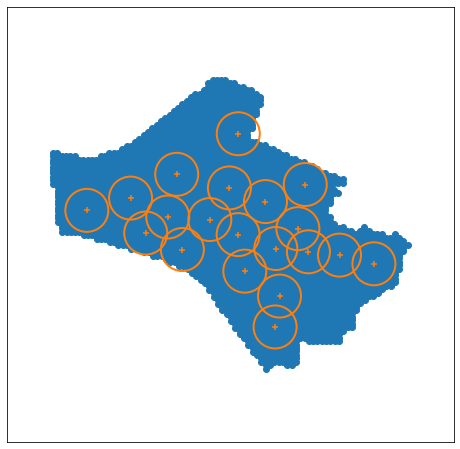

In [83]:
plot_result(points,opt_sites,radius)

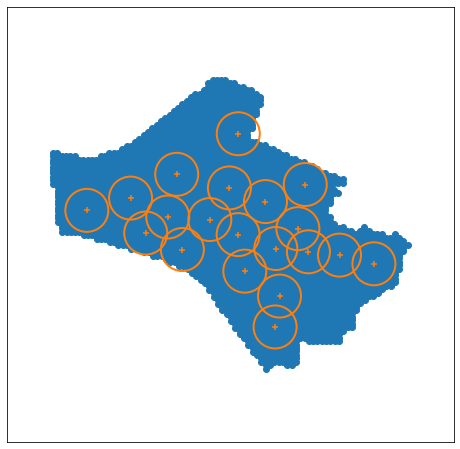

In [84]:
plot_result(points,opt_sites,radius)

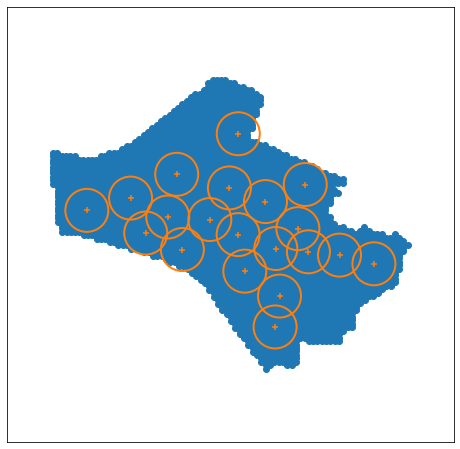

In [85]:
plot_result(points,opt_sites,radius)

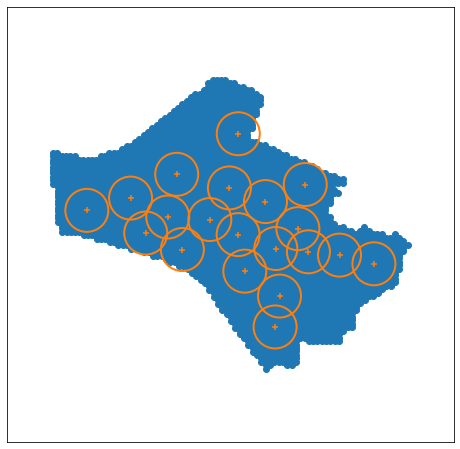

In [86]:
plot_result(points,opt_sites,radius)

강서구
----- Configurations -----
  Number of points 4140
  K 1
  Radius 0.00563444
----- Output -----
  Running time : 1.356947660446167 seconds
  Optimal coverage points: 29.4256
----- Configurations -----
  Number of points 4140
  K 2
  Radius 0.00563444
----- Output -----
  Running time : 1.2067859172821045 seconds
  Optimal coverage points: 53.3901
----- Configurations -----
  Number of points 4140
  K 3
  Radius 0.00563444
----- Output -----
  Running time : 1.1791656017303467 seconds
  Optimal coverage points: 76.1285
----- Configurations -----
  Number of points 4140
  K 4
  Radius 0.00563444
----- Output -----
  Running time : 1.2336883544921875 seconds
  Optimal coverage points: 98.4148
----- Configurations -----
  Number of points 4140
  K 5
  Radius 0.00563444
----- Output -----
  Running time : 1.211294412612915 seconds
  Optimal coverage points: 118.797
----- Configurations -----
  Number of points 4140
  K 6
  Radius 0.00563444
----- Output -----
  Running time : 1.29730892

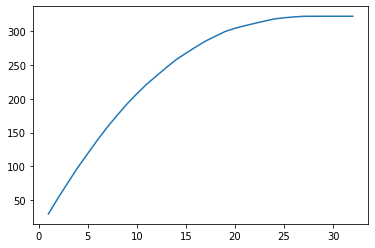

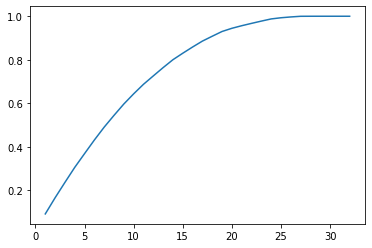

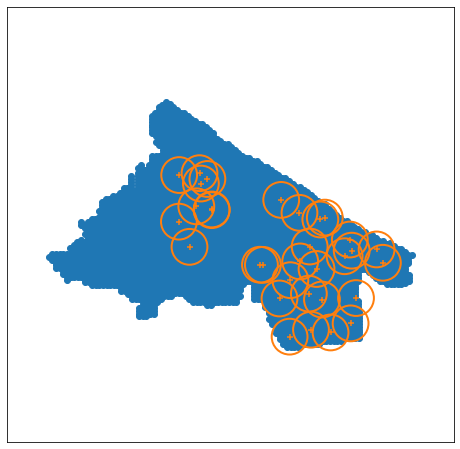

송파구
----- Configurations -----
  Number of points 3382
  K 1
  Radius 0.00563444
----- Output -----
  Running time : 1.4508271217346191 seconds
  Optimal coverage points: 21.671
----- Configurations -----
  Number of points 3382
  K 2
  Radius 0.00563444
----- Output -----
  Running time : 1.351564645767212 seconds
  Optimal coverage points: 41.8817
----- Configurations -----
  Number of points 3382
  K 3
  Radius 0.00563444
----- Output -----
  Running time : 1.384115219116211 seconds
  Optimal coverage points: 60.3659
----- Configurations -----
  Number of points 3382
  K 4
  Radius 0.00563444
----- Output -----
  Running time : 1.4354844093322754 seconds
  Optimal coverage points: 78.3702
----- Configurations -----
  Number of points 3382
  K 5
  Radius 0.00563444
----- Output -----
  Running time : 1.6983938217163086 seconds
  Optimal coverage points: 95.2603
----- Configurations -----
  Number of points 3382
  K 6
  Radius 0.00563444
----- Output -----
  Running time : 1.468082427

----- Output -----
  Running time : 1.2825305461883545 seconds
  Optimal coverage points: 341.039
----- Configurations -----
  Number of points 3382
  K 49
  Radius 0.00563444
----- Output -----
  Running time : 1.0542089939117432 seconds
  Optimal coverage points: 341.067
----- Configurations -----
  Number of points 3382
  K 50
  Radius 0.00563444
----- Output -----
  Running time : 1.0203921794891357 seconds
  Optimal coverage points: 341.067
----- Configurations -----
  Number of points 3382
  K 51
  Radius 0.00563444
----- Output -----
  Running time : 1.0619492530822754 seconds
  Optimal coverage points: 341.067
----- Configurations -----
  Number of points 3382
  K 52
  Radius 0.00563444
----- Output -----
  Running time : 0.9504475593566895 seconds
  Optimal coverage points: 341.067
----- Configurations -----
  Number of points 3382
  K 53
  Radius 0.00563444
----- Output -----
  Running time : 1.051299810409546 seconds
  Optimal coverage points: 341.067
----- Configurations --

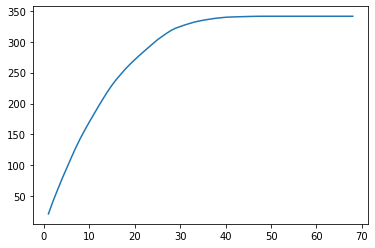

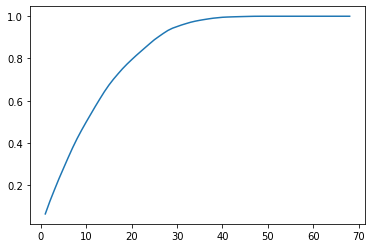

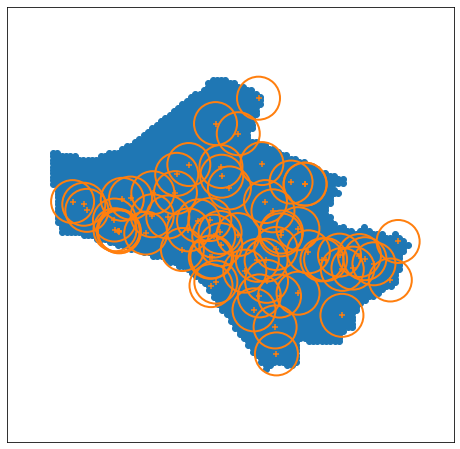

강남구
----- Configurations -----
  Number of points 3942
  K 1
  Radius 0.00563444
----- Output -----
  Running time : 1.2741568088531494 seconds
  Optimal coverage points: 20.6865
----- Configurations -----
  Number of points 3942
  K 2
  Radius 0.00563444
----- Output -----
  Running time : 1.2945342063903809 seconds
  Optimal coverage points: 38.6181
----- Configurations -----
  Number of points 3942
  K 3
  Radius 0.00563444
----- Output -----
  Running time : 1.263988733291626 seconds
  Optimal coverage points: 55.0539
----- Configurations -----
  Number of points 3942
  K 4
  Radius 0.00563444
----- Output -----
  Running time : 1.2891004085540771 seconds
  Optimal coverage points: 71.1428
----- Configurations -----
  Number of points 3942
  K 5
  Radius 0.00563444
----- Output -----
  Running time : 1.2825303077697754 seconds
  Optimal coverage points: 86.4933
----- Configurations -----
  Number of points 3942
  K 6
  Radius 0.00563444
----- Output -----
  Running time : 1.2023627

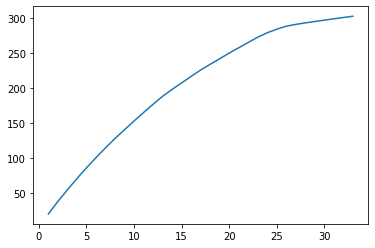

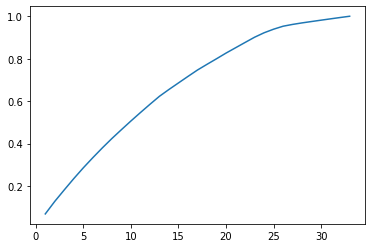

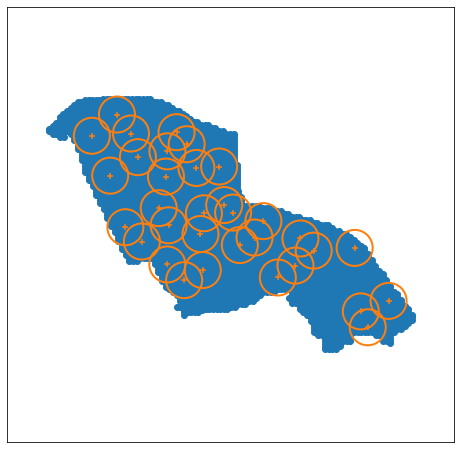

관악구
----- Configurations -----
  Number of points 2956
  K 1
  Radius 0.00563444
----- Output -----
  Running time : 1.0360331535339355 seconds
  Optimal coverage points: 30.0467
----- Configurations -----
  Number of points 2956
  K 2
  Radius 0.00563444
----- Output -----
  Running time : 1.1059026718139648 seconds
  Optimal coverage points: 57.2249
----- Configurations -----
  Number of points 2956
  K 3
  Radius 0.00563444
----- Output -----
  Running time : 0.9019412994384766 seconds
  Optimal coverage points: 81.9238
----- Configurations -----
  Number of points 2956
  K 4
  Radius 0.00563444
----- Output -----
  Running time : 0.8847031593322754 seconds
  Optimal coverage points: 105.861
----- Configurations -----
  Number of points 2956
  K 5
  Radius 0.00563444
----- Output -----
  Running time : 0.952714204788208 seconds
  Optimal coverage points: 128.472
----- Configurations -----
  Number of points 2956
  K 6
  Radius 0.00563444
----- Output -----
  Running time : 1.9132971

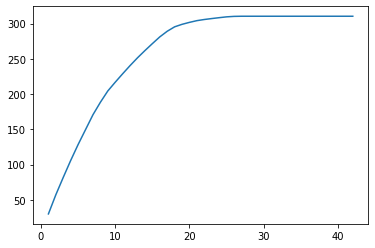

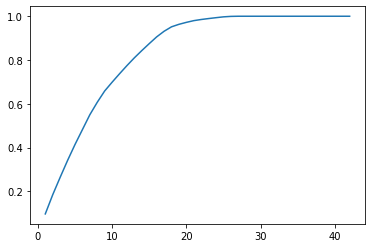

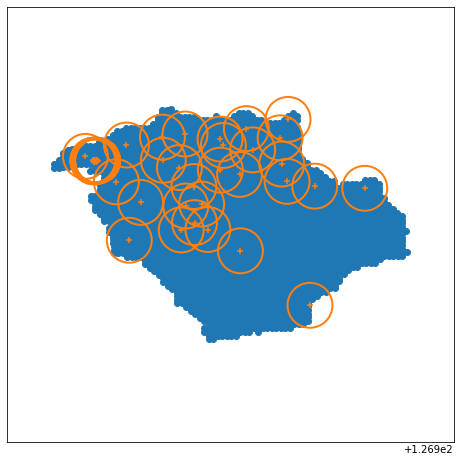

노원구
----- Configurations -----
  Number of points 3559
  K 1
  Radius 0.00563444
----- Output -----
  Running time : 1.1831400394439697 seconds
  Optimal coverage points: 28.5021
----- Configurations -----
  Number of points 3559
  K 2
  Radius 0.00563444
----- Output -----
  Running time : 0.9144821166992188 seconds
  Optimal coverage points: 54.4407
----- Configurations -----
  Number of points 3559
  K 3
  Radius 0.00563444
----- Output -----
  Running time : 0.934748649597168 seconds
  Optimal coverage points: 80.0656
----- Configurations -----
  Number of points 3559
  K 4
  Radius 0.00563444
----- Output -----
  Running time : 2.2889227867126465 seconds
  Optimal coverage points: 102.082
----- Configurations -----
  Number of points 3559
  K 5
  Radius 0.00563444
----- Output -----
  Running time : 2.222299098968506 seconds
  Optimal coverage points: 123.882
----- Configurations -----
  Number of points 3559
  K 6
  Radius 0.00563444
----- Output -----
  Running time : 1.12064337

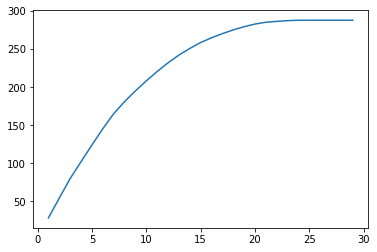

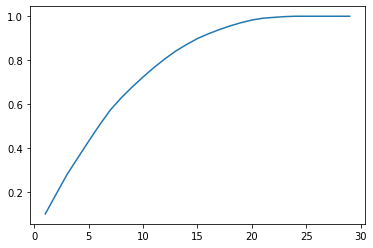

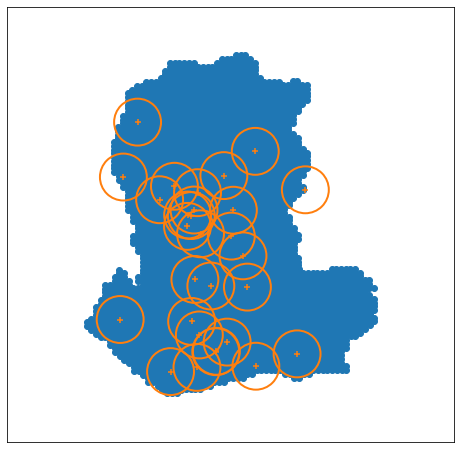

은평구
----- Configurations -----
  Number of points 2987
  K 1
  Radius 0.00563444
----- Output -----
  Running time : 0.8938827514648438 seconds
  Optimal coverage points: 29.4065
----- Configurations -----
  Number of points 2987
  K 2
  Radius 0.00563444
----- Output -----
  Running time : 0.8520874977111816 seconds
  Optimal coverage points: 56.1347
----- Configurations -----
  Number of points 2987
  K 3
  Radius 0.00563444
----- Output -----
  Running time : 0.7918832302093506 seconds
  Optimal coverage points: 82.0364
----- Configurations -----
  Number of points 2987
  K 4
  Radius 0.00563444
----- Output -----
  Running time : 0.7470064163208008 seconds
  Optimal coverage points: 107.383
----- Configurations -----
  Number of points 2987
  K 5
  Radius 0.00563444
----- Output -----
  Running time : 0.7549796104431152 seconds
  Optimal coverage points: 128.787
----- Configurations -----
  Number of points 2987
  K 6
  Radius 0.00563444
----- Output -----
  Running time : 0.929514

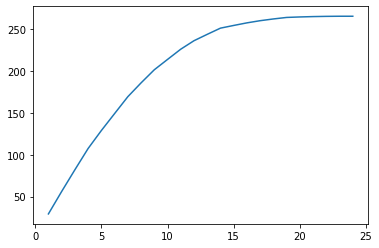

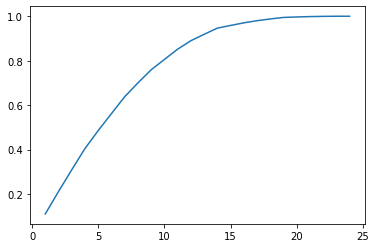

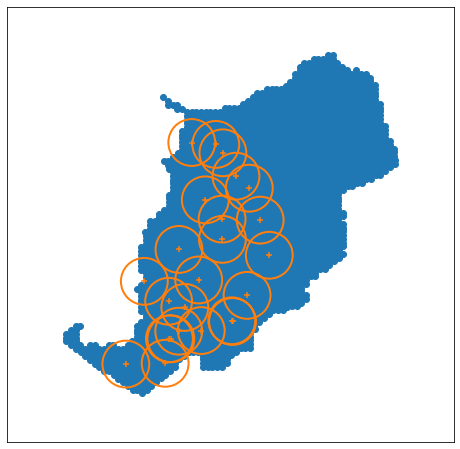

서초구
----- Configurations -----
  Number of points 4684
  K 1
  Radius 0.00563444
----- Output -----
  Running time : 0.9474654197692871 seconds
  Optimal coverage points: 22.7385
----- Configurations -----
  Number of points 4684
  K 2
  Radius 0.00563444
----- Output -----
  Running time : 0.8135688304901123 seconds
  Optimal coverage points: 44.4507
----- Configurations -----
  Number of points 4684
  K 3
  Radius 0.00563444
----- Output -----
  Running time : 0.8092219829559326 seconds
  Optimal coverage points: 62.225
----- Configurations -----
  Number of points 4684
  K 4
  Radius 0.00563444
----- Output -----
  Running time : 1.1051454544067383 seconds
  Optimal coverage points: 77.0486
----- Configurations -----
  Number of points 4684
  K 5
  Radius 0.00563444
----- Output -----
  Running time : 0.8337678909301758 seconds
  Optimal coverage points: 91.5874
----- Configurations -----
  Number of points 4684
  K 6
  Radius 0.00563444
----- Output -----
  Running time : 0.8050315

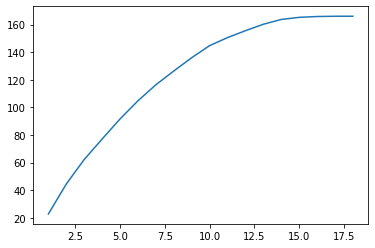

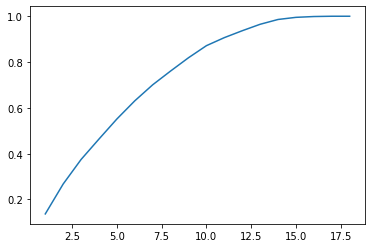

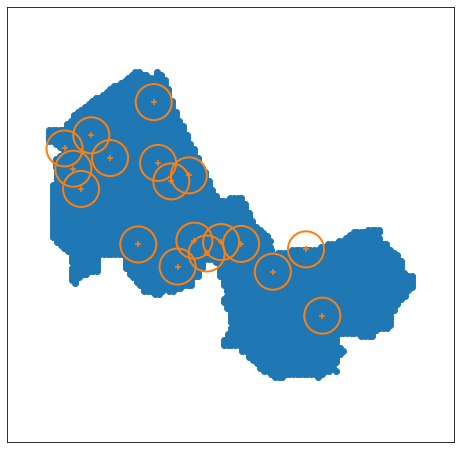

마포구
----- Configurations -----
  Number of points 2384
  K 1
  Radius 0.00563444
----- Output -----
  Running time : 0.8297750949859619 seconds
  Optimal coverage points: 33.672
----- Configurations -----
  Number of points 2384
  K 2
  Radius 0.00563444
----- Output -----
  Running time : 0.8736350536346436 seconds
  Optimal coverage points: 65.9427
----- Configurations -----
  Number of points 2384
  K 3
  Radius 0.00563444
----- Output -----
  Running time : 0.8337697982788086 seconds
  Optimal coverage points: 96.2055
----- Configurations -----
  Number of points 2384
  K 4
  Radius 0.00563444
----- Output -----
  Running time : 0.9158871173858643 seconds
  Optimal coverage points: 121.837
----- Configurations -----
  Number of points 2384
  K 5
  Radius 0.00563444
----- Output -----
  Running time : 0.7824716567993164 seconds
  Optimal coverage points: 142.588
----- Configurations -----
  Number of points 2384
  K 6
  Radius 0.00563444
----- Output -----
  Running time : 0.8705656

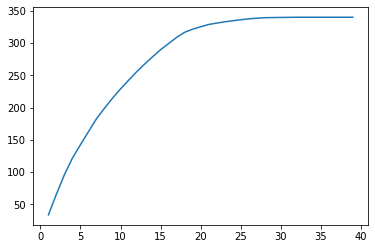

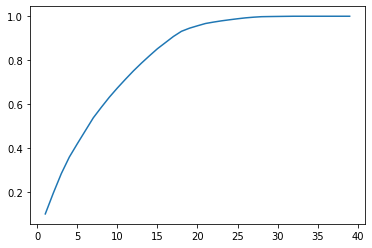

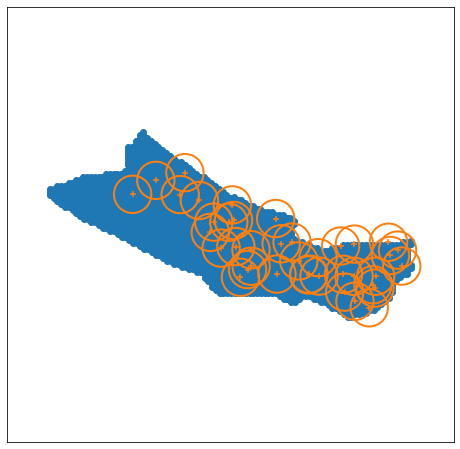

성북구
----- Configurations -----
  Number of points 2457
  K 1
  Radius 0.00563444
----- Output -----
  Running time : 0.7120945453643799 seconds
  Optimal coverage points: 31.5604
----- Configurations -----
  Number of points 2457
  K 2
  Radius 0.00563444
----- Output -----
  Running time : 0.8328144550323486 seconds
  Optimal coverage points: 57.5792
----- Configurations -----
  Number of points 2457
  K 3
  Radius 0.00563444
----- Output -----
  Running time : 0.7628269195556641 seconds
  Optimal coverage points: 81.8334
----- Configurations -----
  Number of points 2457
  K 4
  Radius 0.00563444
----- Output -----
  Running time : 1.0372769832611084 seconds
  Optimal coverage points: 105.244
----- Configurations -----
  Number of points 2457
  K 5
  Radius 0.00563444
----- Output -----
  Running time : 0.8128623962402344 seconds
  Optimal coverage points: 127.401
----- Configurations -----
  Number of points 2457
  K 6
  Radius 0.00563444
----- Output -----
  Running time : 0.735010

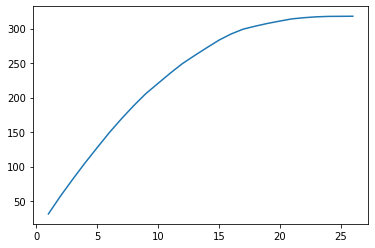

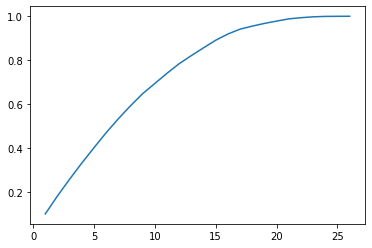

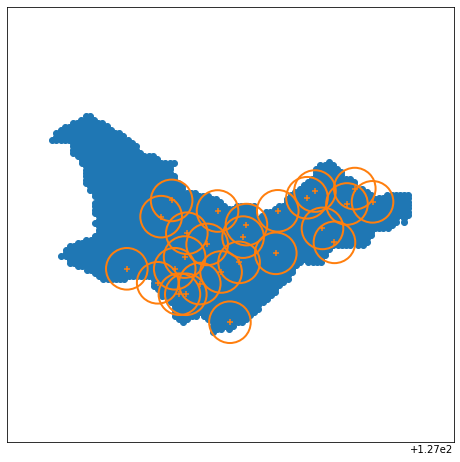

영등포구
----- Configurations -----
  Number of points 2453
  K 1
  Radius 0.00563444
----- Output -----
  Running time : 0.7774815559387207 seconds
  Optimal coverage points: 25.4424
----- Configurations -----
  Number of points 2453
  K 2
  Radius 0.00563444
----- Output -----
  Running time : 0.7885479927062988 seconds
  Optimal coverage points: 47.7742
----- Configurations -----
  Number of points 2453
  K 3
  Radius 0.00563444
----- Output -----
  Running time : 0.7450125217437744 seconds
  Optimal coverage points: 69.4796
----- Configurations -----
  Number of points 2453
  K 4
  Radius 0.00563444
----- Output -----
  Running time : 0.771613359451294 seconds
  Optimal coverage points: 88.9666
----- Configurations -----
  Number of points 2453
  K 5
  Radius 0.00563444
----- Output -----
  Running time : 0.7613525390625 seconds
  Optimal coverage points: 108.31
----- Configurations -----
  Number of points 2453
  K 6
  Radius 0.00563444
----- Output -----
  Running time : 0.7313539981

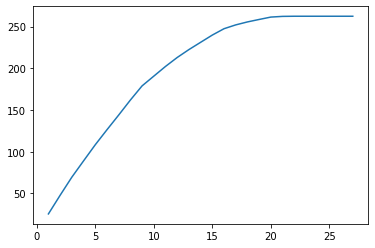

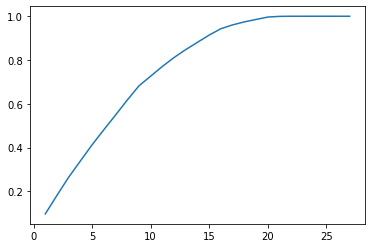

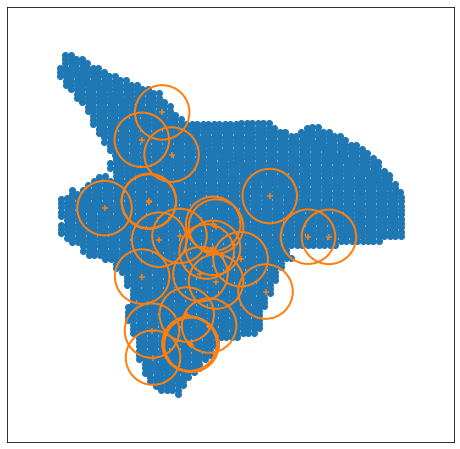

동작구
----- Configurations -----
  Number of points 1642
  K 1
  Radius 0.00563444
----- Output -----
  Running time : 0.7676095962524414 seconds
  Optimal coverage points: 30.9894
----- Configurations -----
  Number of points 1642
  K 2
  Radius 0.00563444
----- Output -----
  Running time : 0.7170593738555908 seconds
  Optimal coverage points: 58.4637
----- Configurations -----
  Number of points 1642
  K 3
  Radius 0.00563444
----- Output -----
  Running time : 0.6163816452026367 seconds
  Optimal coverage points: 85.7303
----- Configurations -----
  Number of points 1642
  K 4
  Radius 0.00563444
----- Output -----
  Running time : 0.6191723346710205 seconds
  Optimal coverage points: 103.821
----- Configurations -----
  Number of points 1642
  K 5
  Radius 0.00563444
----- Output -----
  Running time : 0.7358241081237793 seconds
  Optimal coverage points: 121.045
----- Configurations -----
  Number of points 1642
  K 6
  Radius 0.00563444
----- Output -----
  Running time : 0.711797

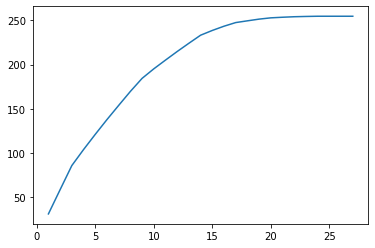

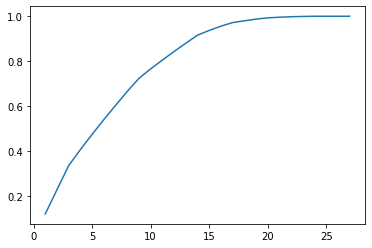

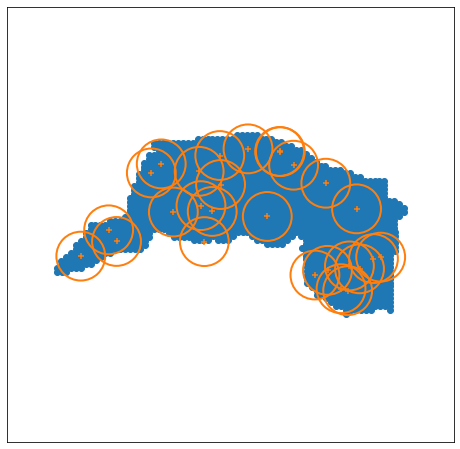

중랑구
----- Configurations -----
  Number of points 1847
  K 1
  Radius 0.00563444
----- Output -----
  Running time : 0.6712641716003418 seconds
  Optimal coverage points: 24.8279
----- Configurations -----
  Number of points 1847
  K 2
  Radius 0.00563444
----- Output -----
  Running time : 0.5914392471313477 seconds
  Optimal coverage points: 49.6033
----- Configurations -----
  Number of points 1847
  K 3
  Radius 0.00563444
----- Output -----
  Running time : 0.5964035987854004 seconds
  Optimal coverage points: 74.2104
----- Configurations -----
  Number of points 1847
  K 4
  Radius 0.00563444
----- Output -----
  Running time : 0.6182539463043213 seconds
  Optimal coverage points: 96.1174
----- Configurations -----
  Number of points 1847
  K 5
  Radius 0.00563444
----- Output -----
  Running time : 0.5820884704589844 seconds
  Optimal coverage points: 116.67
----- Configurations -----
  Number of points 1847
  K 6
  Radius 0.00563444
----- Output -----
  Running time : 0.6841683

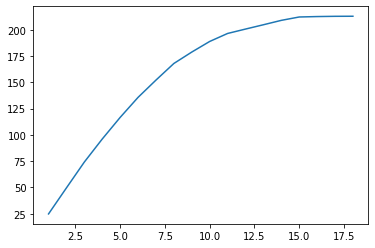

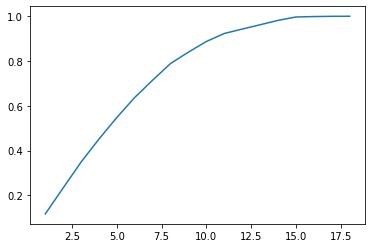

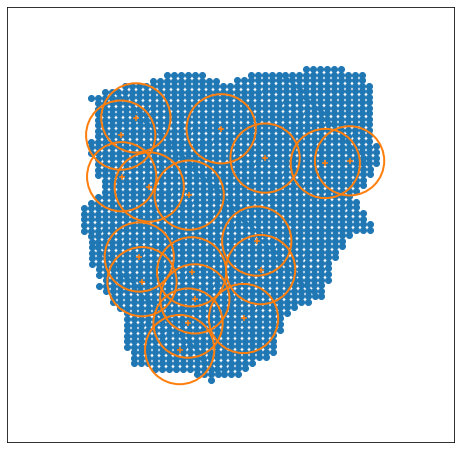

양천구
----- Configurations -----
  Number of points 1737
  K 1
  Radius 0.00563444
----- Output -----
  Running time : 0.6921732425689697 seconds
  Optimal coverage points: 20.0028
----- Configurations -----
  Number of points 1737
  K 2
  Radius 0.00563444
----- Output -----
  Running time : 0.6754360198974609 seconds
  Optimal coverage points: 39.5919
----- Configurations -----
  Number of points 1737
  K 3
  Radius 0.00563444
----- Output -----
  Running time : 0.6179425716400146 seconds
  Optimal coverage points: 56.0185
----- Configurations -----
  Number of points 1737
  K 4
  Radius 0.00563444
----- Output -----
  Running time : 0.7250988483428955 seconds
  Optimal coverage points: 69.727
----- Configurations -----
  Number of points 1737
  K 5
  Radius 0.00563444
----- Output -----
  Running time : 0.7491743564605713 seconds
  Optimal coverage points: 83.2165
----- Configurations -----
  Number of points 1737
  K 6
  Radius 0.00563444
----- Output -----
  Running time : 0.6778256

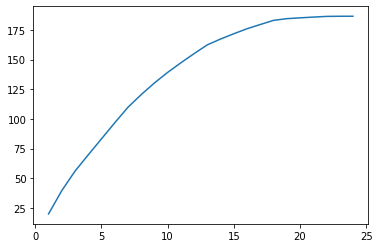

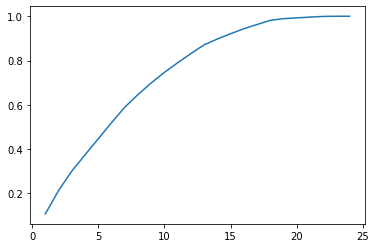

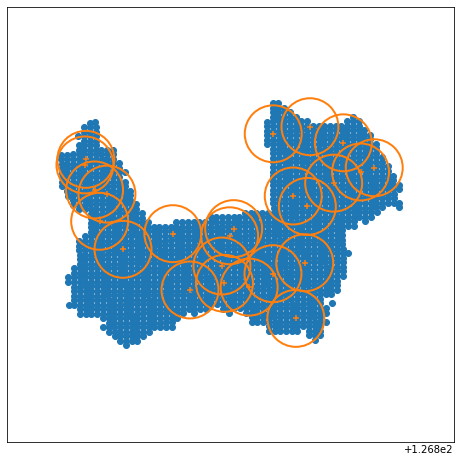

구로구
----- Configurations -----
  Number of points 2005
  K 1
  Radius 0.00563444
----- Output -----
  Running time : 0.7470014095306396 seconds
  Optimal coverage points: 23.4929
----- Configurations -----
  Number of points 2005
  K 2
  Radius 0.00563444
----- Output -----
  Running time : 0.6343033313751221 seconds
  Optimal coverage points: 46.5026
----- Configurations -----
  Number of points 2005
  K 3
  Radius 0.00563444
----- Output -----
  Running time : 0.7639565467834473 seconds
  Optimal coverage points: 69.2105
----- Configurations -----
  Number of points 2005
  K 4
  Radius 0.00563444
----- Output -----
  Running time : 0.6602754592895508 seconds
  Optimal coverage points: 89.6524
----- Configurations -----
  Number of points 2005
  K 5
  Radius 0.00563444
----- Output -----
  Running time : 0.6996080875396729 seconds
  Optimal coverage points: 109.831
----- Configurations -----
  Number of points 2005
  K 6
  Radius 0.00563444
----- Output -----
  Running time : 0.736069

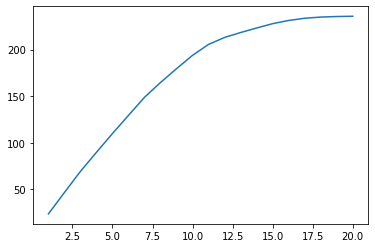

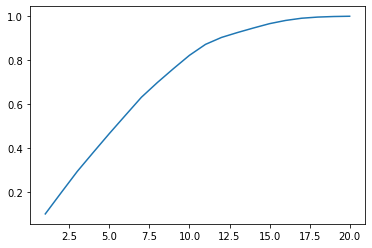

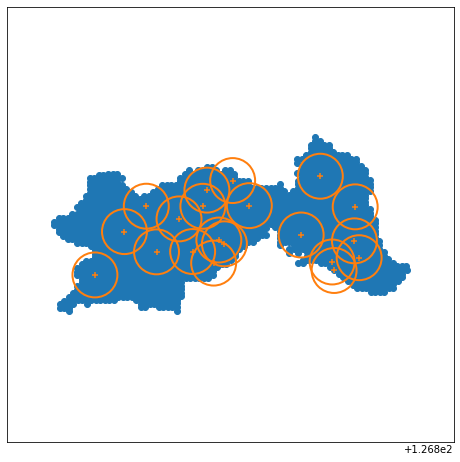

동대문구
----- Configurations -----
  Number of points 1426
  K 1
  Radius 0.00563444
----- Output -----
  Running time : 0.6582391262054443 seconds
  Optimal coverage points: 22.6549
----- Configurations -----
  Number of points 1426
  K 2
  Radius 0.00563444
----- Output -----
  Running time : 0.5376675128936768 seconds
  Optimal coverage points: 45.1983
----- Configurations -----
  Number of points 1426
  K 3
  Radius 0.00563444
----- Output -----
  Running time : 0.5754609107971191 seconds
  Optimal coverage points: 64.1253
----- Configurations -----
  Number of points 1426
  K 4
  Radius 0.00563444
----- Output -----
  Running time : 0.5575084686279297 seconds
  Optimal coverage points: 82.289
----- Configurations -----
  Number of points 1426
  K 5
  Radius 0.00563444
----- Output -----
  Running time : 0.5669169425964355 seconds
  Optimal coverage points: 98.4411
----- Configurations -----
  Number of points 1426
  K 6
  Radius 0.00563444
----- Output -----
  Running time : 0.658711

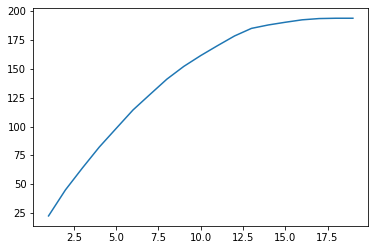

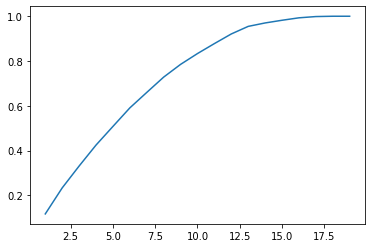

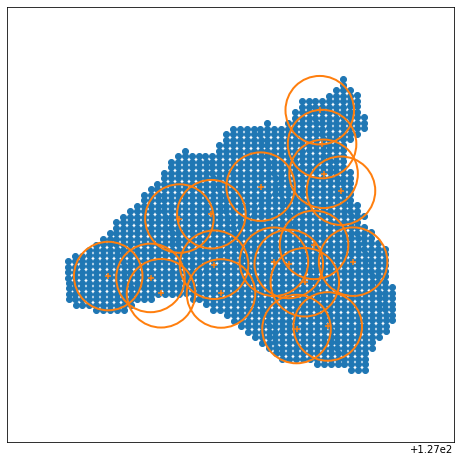

광진구
----- Configurations -----
  Number of points 1702
  K 1
  Radius 0.00563444
----- Output -----
  Running time : 0.6410715579986572 seconds
  Optimal coverage points: 26.3531
----- Configurations -----
  Number of points 1702
  K 2
  Radius 0.00563444
----- Output -----
  Running time : 0.5722675323486328 seconds
  Optimal coverage points: 47.702
----- Configurations -----
  Number of points 1702
  K 3
  Radius 0.00563444
----- Output -----
  Running time : 0.6206295490264893 seconds
  Optimal coverage points: 68.028
----- Configurations -----
  Number of points 1702
  K 4
  Radius 0.00563444
----- Output -----
  Running time : 0.6748805046081543 seconds
  Optimal coverage points: 88.1702
----- Configurations -----
  Number of points 1702
  K 5
  Radius 0.00563444
----- Output -----
  Running time : 0.6581106185913086 seconds
  Optimal coverage points: 105.244
----- Configurations -----
  Number of points 1702
  K 6
  Radius 0.00563444
----- Output -----
  Running time : 0.66415643

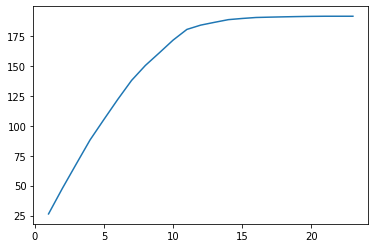

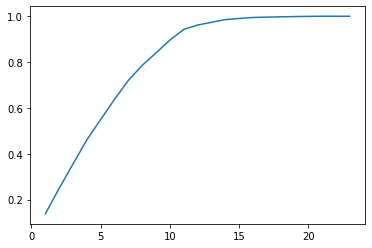

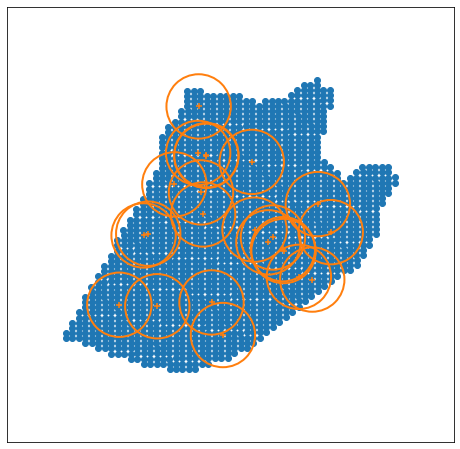

성동구
----- Configurations -----
  Number of points 1678
  K 1
  Radius 0.00563444
----- Output -----
  Running time : 0.6473512649536133 seconds
  Optimal coverage points: 35.7518
----- Configurations -----
  Number of points 1678
  K 2
  Radius 0.00563444
----- Output -----
  Running time : 0.6389238834381104 seconds
  Optimal coverage points: 70.3538
----- Configurations -----
  Number of points 1678
  K 3
  Radius 0.00563444
----- Output -----
  Running time : 0.62333083152771 seconds
  Optimal coverage points: 91.8578
----- Configurations -----
  Number of points 1678
  K 4
  Radius 0.00563444
----- Output -----
  Running time : 1.4098584651947021 seconds
  Optimal coverage points: 113.032
----- Configurations -----
  Number of points 1678
  K 5
  Radius 0.00563444
----- Output -----
  Running time : 0.6492941379547119 seconds
  Optimal coverage points: 132.551
----- Configurations -----
  Number of points 1678
  K 6
  Radius 0.00563444
----- Output -----
  Running time : 0.67818522

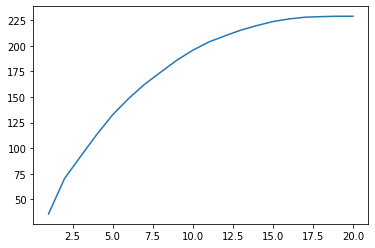

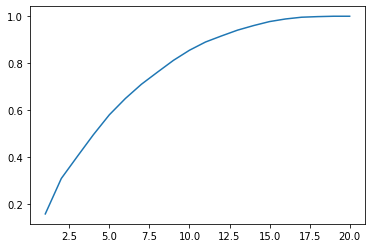

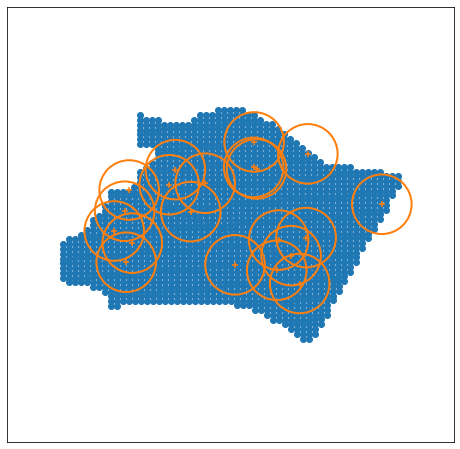

서대문구
----- Configurations -----
  Number of points 1766
  K 1
  Radius 0.00563444
----- Output -----
  Running time : 0.6560852527618408 seconds
  Optimal coverage points: 24.1294
----- Configurations -----
  Number of points 1766
  K 2
  Radius 0.00563444
----- Output -----
  Running time : 0.676192045211792 seconds
  Optimal coverage points: 46.0633
----- Configurations -----
  Number of points 1766
  K 3
  Radius 0.00563444
----- Output -----
  Running time : 0.7044970989227295 seconds
  Optimal coverage points: 65.0066
----- Configurations -----
  Number of points 1766
  K 4
  Radius 0.00563444
----- Output -----
  Running time : 0.6911966800689697 seconds
  Optimal coverage points: 83.6868
----- Configurations -----
  Number of points 1766
  K 5
  Radius 0.00563444
----- Output -----
  Running time : 0.6143975257873535 seconds
  Optimal coverage points: 101.436
----- Configurations -----
  Number of points 1766
  K 6
  Radius 0.00563444
----- Output -----
  Running time : 0.621339

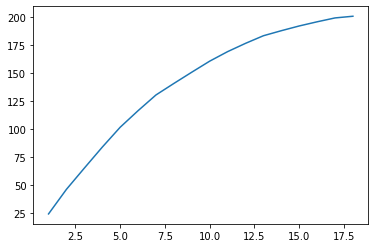

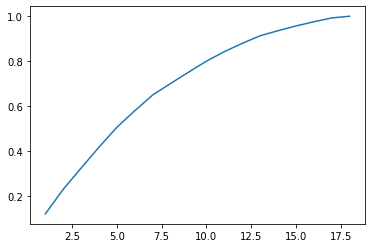

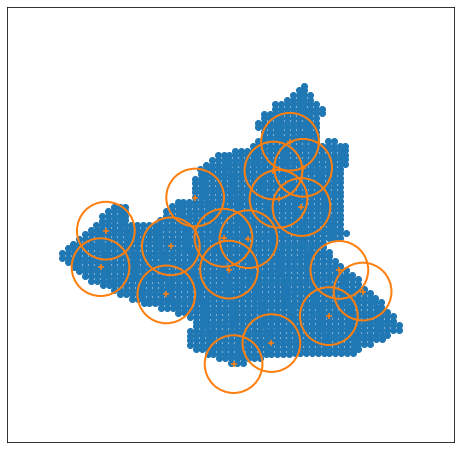

도봉구
----- Configurations -----
  Number of points 2067
  K 1
  Radius 0.00563444
----- Output -----
  Running time : 0.7300467491149902 seconds
  Optimal coverage points: 25.0567
----- Configurations -----
  Number of points 2067
  K 2
  Radius 0.00563444
----- Output -----
  Running time : 0.7260584831237793 seconds
  Optimal coverage points: 45.5043
----- Configurations -----
  Number of points 2067
  K 3
  Radius 0.00563444
----- Output -----
  Running time : 0.6353001594543457 seconds
  Optimal coverage points: 65.1645
----- Configurations -----
  Number of points 2067
  K 4
  Radius 0.00563444
----- Output -----
  Running time : 0.8094913959503174 seconds
  Optimal coverage points: 84.5793
----- Configurations -----
  Number of points 2067
  K 5
  Radius 0.00563444
----- Output -----
  Running time : 0.7011222839355469 seconds
  Optimal coverage points: 103.611
----- Configurations -----
  Number of points 2067
  K 6
  Radius 0.00563444
----- Output -----
  Running time : 0.686200

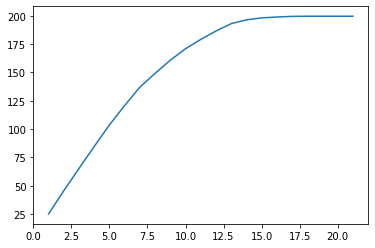

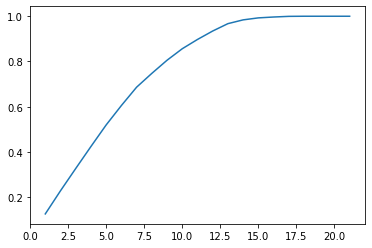

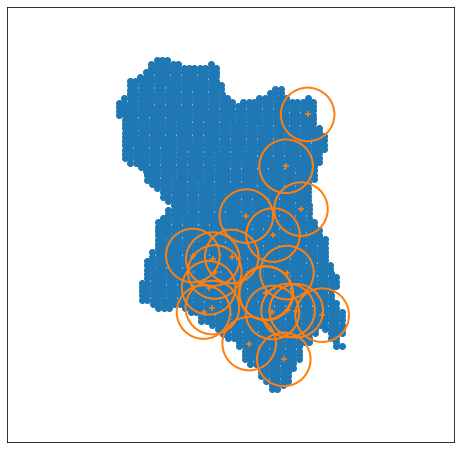

강북구
----- Configurations -----
  Number of points 2364
  K 1
  Radius 0.00563444
----- Output -----
  Running time : 0.6444635391235352 seconds
  Optimal coverage points: 28.0912
----- Configurations -----
  Number of points 2364
  K 2
  Radius 0.00563444
----- Output -----
  Running time : 0.670072078704834 seconds
  Optimal coverage points: 55.2543
----- Configurations -----
  Number of points 2364
  K 3
  Radius 0.00563444
----- Output -----
  Running time : 0.651538610458374 seconds
  Optimal coverage points: 79.9385
----- Configurations -----
  Number of points 2364
  K 4
  Radius 0.00563444
----- Output -----
  Running time : 0.634239673614502 seconds
  Optimal coverage points: 103.389
----- Configurations -----
  Number of points 2364
  K 5
  Radius 0.00563444
----- Output -----
  Running time : 0.6415555477142334 seconds
  Optimal coverage points: 123.385
----- Configurations -----
  Number of points 2364
  K 6
  Radius 0.00563444
----- Output -----
  Running time : 0.656015157

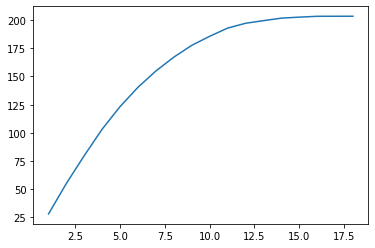

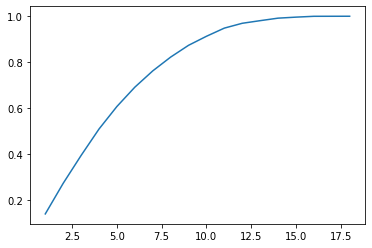

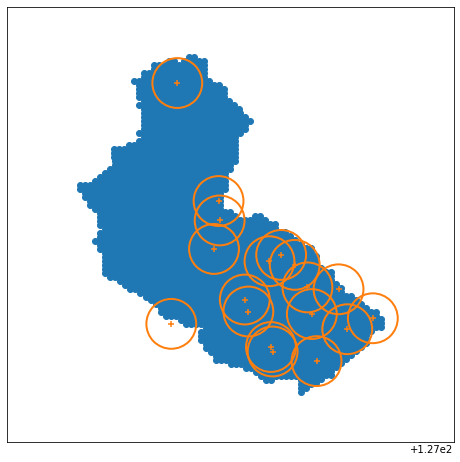

용산구
----- Configurations -----
  Number of points 2187
  K 1
  Radius 0.00563444
----- Output -----
  Running time : 0.731041431427002 seconds
  Optimal coverage points: 23.4229
----- Configurations -----
  Number of points 2187
  K 2
  Radius 0.00563444
----- Output -----
  Running time : 0.606400728225708 seconds
  Optimal coverage points: 42.4699
----- Configurations -----
  Number of points 2187
  K 3
  Radius 0.00563444
----- Output -----
  Running time : 0.6839938163757324 seconds
  Optimal coverage points: 60.0186
----- Configurations -----
  Number of points 2187
  K 4
  Radius 0.00563444
----- Output -----
  Running time : 0.7599656581878662 seconds
  Optimal coverage points: 75.4278
----- Configurations -----
  Number of points 2187
  K 5
  Radius 0.00563444
----- Output -----
  Running time : 0.7569727897644043 seconds
  Optimal coverage points: 89.9905
----- Configurations -----
  Number of points 2187
  K 6
  Radius 0.00563444
----- Output -----
  Running time : 0.63980460

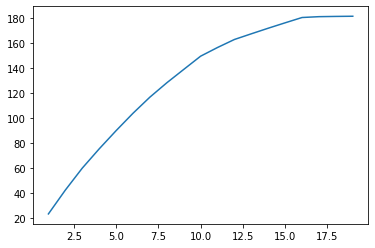

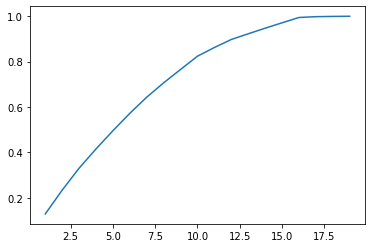

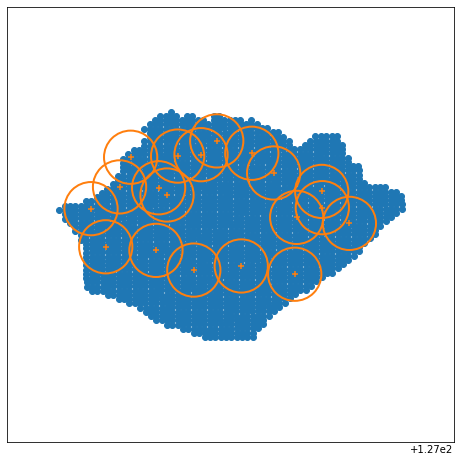

중구
----- Configurations -----
  Number of points 1001
  K 1
  Radius 0.00563444
----- Output -----
  Running time : 0.5711972713470459 seconds
  Optimal coverage points: 20.0522
----- Configurations -----
  Number of points 1001
  K 2
  Radius 0.00563444
----- Output -----
  Running time : 0.552546501159668 seconds
  Optimal coverage points: 40.0964
----- Configurations -----
  Number of points 1001
  K 3
  Radius 0.00563444
----- Output -----
  Running time : 0.5513119697570801 seconds
  Optimal coverage points: 57.5043
----- Configurations -----
  Number of points 1001
  K 4
  Radius 0.00563444
----- Output -----
  Running time : 0.5672516822814941 seconds
  Optimal coverage points: 73.9419
----- Configurations -----
  Number of points 1001
  K 5
  Radius 0.00563444
----- Output -----
  Running time : 0.5445816516876221 seconds
  Optimal coverage points: 89.3342
----- Configurations -----
  Number of points 1001
  K 6
  Radius 0.00563444
----- Output -----
  Running time : 0.67532873

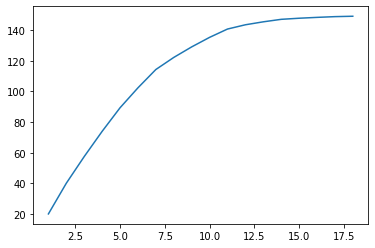

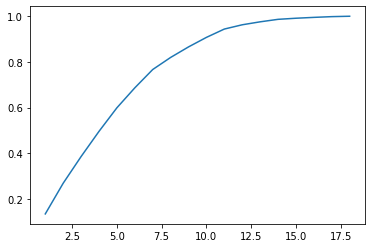

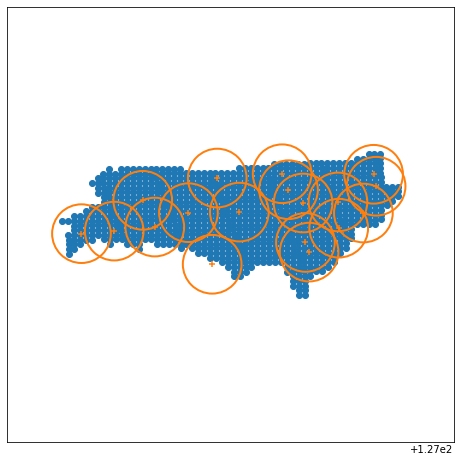

종로구
----- Configurations -----
  Number of points 2400
  K 1
  Radius 0.00563444
----- Output -----
  Running time : 0.834770679473877 seconds
  Optimal coverage points: 18.6004
----- Configurations -----
  Number of points 2400
  K 2
  Radius 0.00563444
----- Output -----
  Running time : 0.825688362121582 seconds
  Optimal coverage points: 36.1075
----- Configurations -----
  Number of points 2400
  K 3
  Radius 0.00563444
----- Output -----
  Running time : 0.75480055809021 seconds
  Optimal coverage points: 52.8921
----- Configurations -----
  Number of points 2400
  K 4
  Radius 0.00563444
----- Output -----
  Running time : 1.0706801414489746 seconds
  Optimal coverage points: 68.1643
----- Configurations -----
  Number of points 2400
  K 5
  Radius 0.00563444
----- Output -----
  Running time : 0.8477332592010498 seconds
  Optimal coverage points: 82.759
----- Configurations -----
  Number of points 2400
  K 6
  Radius 0.00563444
----- Output -----
  Running time : 0.96182847023

KeyboardInterrupt: 

In [92]:
for gu in gu_rank_df['0'][:25]:
  print(gu)
  sites = np.asarray([[xcoord, ycoord] for xcoord, ycoord in zip(facilities[facilities['구']==gu]['xcoord'], facilities[facilities['구']==gu]['ycoord']) ])
  points = np.asarray([[xcoord, ycoord] for xcoord, ycoord in zip(mclp_data[mclp_data['구']==gu]['xcoord'], mclp_data[mclp_data['구']==gu]['ycoord']) ])
  w = mclp_data[mclp_data['구']==gu]['입지점수'].to_list()
  #500m 커버
  f_list = []
  for i in range(1,len(sites)):
    opt_sites,f = mclp(points, i, radius, w, sites)
    f_list.append(f)
  plt.plot(range(1,len(sites)), np.asarray( f_list) )
  plt.show()
  plt.plot(range(1,len(sites)), np.asarray( f_list)/f_list[-1] )
  plt.show()
  plot_result(points,opt_sites,radius)